## 1. Problem statement
1. Predict ratings of the Top 250 movies of all time on IMDB using tree-based ML models (decision trees and ensemble methods)
2. Determine the top 2 features that predict ratings for the best tree-based model

## 2. Data collection
1. Get list of Top 250 movie names directly from IMDB
2. Use these names in the OMDB API to get additional details on the movie, including plot synopsis

#### 2.1 Get movie names

In [712]:
# Import libraries needed for this step
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [2]:
# Top 250 movies URL
url = "http://www.imdb.com/chart/top"

In [480]:
# Get Top 250 movie table
df_aslist = (pd.read_html(url, attrs = {'class': 'chart full-width'}))
df = df_aslist[0]
df.head()

,Unnamed: 0,Rank & Title,IMDb Rating,Your Rating,Unnamed: 4
0,NaN,1. The Shawshank Redemption (1994),9.2,12345678910 NOT YET RELEASED Seen,NaN
1,NaN,2. The Godfather (1972),9.2,12345678910 NOT YET RELEASED Seen,NaN
2,NaN,3. The Godfather: Part II (1974),9.0,12345678910 NOT YET RELEASED Seen,NaN
3,NaN,4. The Dark Knight (2008),8.9,12345678910 NOT YET RELEASED Seen,NaN
4,NaN,5. 12 Angry Men (1957),8.9,12345678910 NOT YET RELEASED Seen,NaN


In [489]:
# Obtain title for API search
import re
name1 = [re.sub(r"[0-9]+\.", "", s) for s in df["Rank & Title"]]
name2 = [re.sub(r"\([0-9]+\)", "", s) for s in name1]
title = [s.strip() for s in name2]

In [482]:
# Obtain year for API search
year1 = [re.findall(r"\([0-9]+\)", s) for s in name1]
year2 = [s[0].strip("\(") for s in year1]
year = [s.strip("\)") for s in year2]

#### 2.2 Get movie details

In [492]:
# Movie details from OMDB API
response = []
for i, t in enumerate(title):
    response.append(requests.get("http://www.omdbapi.com/?t="+t+"&type=movie&y="+year[i]).text)
data = "[" + (",".join(response)) + "]"

In [493]:
# Convert to dataframe
df2 = pd.read_json(data, orient = "records")
df2.head(2)

,Actors,Awards,Country,Director,Error,Genre,Language,Metascore,Plot,Poster,...,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes
0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Nominated for 7 Oscars. Another 19 wins & 30 n...,USA,Frank Darabont,NaN,"Crime, Drama",English,80,Two imprisoned men bond over a number of years...,https://images-na.ssl-images-amazon.com/images...,...,14 Oct 1994,True,142 min,The Shawshank Redemption,movie,"Stephen King (short story ""Rita Hayworth and S...",1994.0,tt0111161,9.3,"1,754,270"
1,"Marlon Brando, Al Pacino, James Caan, Richard ...",Won 3 Oscars. Another 23 wins & 27 nominations.,USA,Francis Ford Coppola,NaN,"Crime, Drama","English, Italian, Latin",100,The aging patriarch of an organized crime dyna...,https://images-na.ssl-images-amazon.com/images...,...,24 Mar 1972,True,175 min,The Godfather,movie,"Mario Puzo (screenplay), Francis Ford Coppola ...",1972.0,tt0068646,9.2,"1,196,702"


## 3. Data Wrangling

In [494]:
df2.dtypes

Actors         object
Awards         object
Country        object
Director       object
Error          object
Genre          object
Language       object
Metascore      object
Plot           object
Poster         object
Rated          object
Released       object
Response       object
Runtime        object
Title          object
Type           object
Writer         object
Year          float64
imdbID         object
imdbRating     object
imdbVotes      object
dtype: object

In [495]:
df2.shape

(250, 21)

In [496]:
# Drop rows with any N/A
del df2["Error"]
df2 = df2.dropna(how = "any")
df2.shape

(244, 20)

In [497]:
# Extract number of Oscars (Nominarted for *OR* Won)
df2["oscar n/w"] = 0
for index, row in df2.iterrows():
    award_s = str(row.ix["Awards"]).split()
 
    if (award_s[0] == "Nominated") and ((award_s[3] == "Oscar.") or (award_s[3] == "Oscars.")):
        df2["oscar n/w"].loc[index] = int(award_s[2])
    elif award_s[0] == "Won" and ((award_s[2] == "Oscar.") or (award_s[2] == "Oscars.")):
        df2["oscar n/w"].loc[index] = int(award_s[1])
    else:
        df2["oscar n/w"].loc[index] = 0

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [498]:
# Extract number of countries
df2["# countries"] = 0
for index, row in df2.iterrows():
    country_s = str(row.ix["Country"]).split(",")
    df2["# countries"].loc[index] = len(country_s)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [499]:
# Remove rows with N/A rating, convert to float
df2 = df2[df2["imdbRating"] != "N/A"]
df2["rating"] = df2["imdbRating"].astype("float")

In [500]:
# Some movie searches not correct via API
df2 = df2[df2["rating"] >= 8]

In [501]:
df2.shape

(243, 23)

In [502]:
# Clean up Runtime column
df2 = df2[df2["Runtime"] != "N/A"]
time = [(re.sub("min", "", s)) for s in df2["Runtime"]]
time_c = [int(s.strip()) if (s != "N/A") else 0 for s in time]
df2["time"] = time_c

In [503]:
# Clean up imdbVotes column
df2 = df2[df2["imdbVotes"] != "N/A"]
df2["votes"] = [int(re.sub(",", "", s)) if (s != "N/A") else 0 for s in df2["imdbVotes"]]

In [504]:
# Get genres using NLP
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cvec = CountVectorizer()

df2_genre = pd.DataFrame(data = cvec.fit_transform(df2["Genre"]).todense(), 
                        columns = cvec.get_feature_names())

In [519]:
# Check that genres were extracted OK
for col in df2_genre.columns:
    if df2_genre[col].isnull().any() == True: print(col)

In [505]:
df2_genre.head()

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,fi,...,music,musical,mystery,noir,romance,sci,sport,thriller,war,western
0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [506]:
# Merge "sci" and "fi", "Film" and "Noir"
df2_genre["sci-fi"] = df2_genre["sci"]
del df2_genre["sci"]
del df2_genre["fi"]
df2_genre["film-noir"] = df2_genre["noir"]
del df2_genre["film"]
del df2_genre["noir"]

In [520]:
# Get languages using NLP

cvec = CountVectorizer(stop_words = "english")

df2_lang = pd.DataFrame(data = cvec.fit_transform(df2["Language"]).todense(), 
                        columns = cvec.get_feature_names())

In [521]:
df2_lang.head()

,american,arabic,belarusian,cantonese,czech,danish,english,esperanto,french,gaelic,...,spanish,swahili,swedish,thai,turkish,urdu,vietnamese,xhosa,yiddish,zulu
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [522]:
# Clean up errors in pulling languages
df2_lang["old-english"] = df2_lang["old"]
eng_correct = [(j - 1) if (df2_lang["old"].loc[i] == 1) else j for i, j in enumerate(df2_lang["english"])]
df2_lang["english"] = eng_correct
del df2_lang["old"]
df2_lang["asl"] = df2_lang["sign"]
del df2_lang["american"]
del df2_lang["sign"]
del df2_lang["language"]

In [523]:
# Check if all columns are OK
for col in df2_lang.columns:
    if df2_lang[col].isnull().any() == True: print(col)

In [510]:
# Convert Year to bins
bins = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
group_names = ["1900s", "1910s", "1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s"]
df2['decade'] = pd.cut(df2['Year'], bins, labels = group_names)

In [524]:
# Build final dataframe
df2_temp = df2[["Rated", "oscar n/w", "# countries", "time", "votes", "rating", "decade", "Title"]]
df2_temp = df2_temp.reset_index()
df2_genre = df2_genre.reset_index()
df2_lang = df2_lang.reset_index()
df_final = pd.concat([df2_temp, df2_genre, df2_lang], axis = 1)

In [525]:
# Remove extra index columns from resetting index
del df_final["index"]

In [527]:
del df_final["level_0"]

In [528]:
# Export to csv for Tableau visualization
df_final.to_csv("P6-5.csv")

In [530]:
df_final.shape

(243, 73)

## 4. Data exploration

#### Distribution of ratings
<img src = "rating.png" width = "300" height = "500">

#### Ratings seem to be higher with more votes
<img src = "votes.png" width = "400" height = "100">

#### There seems to be an optimum runtime for movies with the highest ratings
<img src = "runtime.png" width = "400" height = "100">

#### There seems to be no correlation of ratings with number of Oscars (nominated or won)
<img src = "oscars.png" width = "400" height = "100">

#### There does not seem to be any clear correlation between ratings and the decade when the movie was released
<img src = "decade.png" width = "400" height = "100">


## 5. Model building

In [535]:
# Define X and y
df_title = df_final["Title"]
y = df_final["rating"]
del df_final["Title"]
del df_final["rating"]
X = df_final

In [554]:
# Change decade to numeric ... sklearn only accepts numeric inputs for decision trees
cvec = CountVectorizer()

X_decade = pd.DataFrame(data = cvec.fit_transform(X["decade"]).todense(), 
                        columns = cvec.get_feature_names())
X_decade.head(2)

,1920s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0


In [555]:
# Check if feature extraction went OK
for col in X_decade.columns:
    if X_decade[col].isnull().any() == True: print(col)

In [556]:
# Remove "Rated" and "decade" from X, concat X_decade
del X["Rated"]
del X["decade"]
X = X.reset_index()
X_decade = X_decade.reset_index()
X_final = pd.concat([X, X_decade], axis = 1)

In [559]:
# Remove extra index columns 
del X_final["index"]

In [560]:
# Final check
X_final.shape

(243, 79)

In [561]:
# Final check
y.shape

(243,)

In [637]:
# Split into training and test sets
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size = 0.3, 
                                                    random_state = 42)

#### 5.1 Decision Tree

###### 5.1.1 Model build and performance check

In [638]:
# Build model
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()

In [651]:
# Plot y_pred vs y_test
import matplotlib.pyplot as plt
%matplotlib inline
def make_plot(y_true, y_pred, name):
    plt.xlabel("Actual rating")
    plt.ylabel("Predicted rating")
    plt.title(name)
    plt.scatter(y_true, y_pred)
    plt.show()

In [690]:
# Function for all base models
def base_model(model, name, X_train, X_test, y_train, y_test):
    "Base model characteristics"
# CV scores
    scores = cross_val_score(model, X_train, y_train, cv = 5)
    print(name, "CV Score: ", scores.mean(), "+/-", scores.std())
# Feature importances    
    model.fit(X_train, y_train)
    df = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['importance']).\
                        sort_values('importance', ascending=False)
    print(df[:5])
# Predictions
    y_pred = model.predict(X_test)
    print(name, "predicted MSE: ", mean_squared_error(y_test, y_pred))
    print(name, "predicted R2: ", r2_score(y_test, y_pred))
# Plot
    make_plot(y_test, y_pred, name)

Decision tree CV Score:  -0.019391627437 +/- 0.159752606603
          importance
votes       0.581916
time        0.059038
sicilian    0.048566
1950s       0.036345
western     0.033608
Decision tree predicted MSE:  0.0434246575342
Decision tree predicted R2:  -0.0138000525716


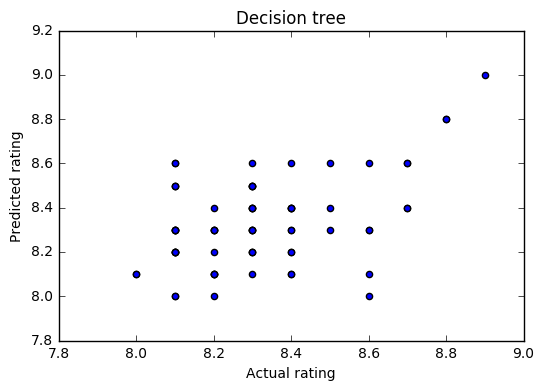

In [691]:
base_model(dtr, "Decision tree", X_train, X_test, y_train, y_test)

###### 5.1.2 Optimize base decision tree

In [692]:
# Set up GridSearch parameters
from sklearn.model_selection import GridSearchCV
params = {"splitter": ['best', 'random'],
          "max_depth": [3,5,10,20],
          "max_features": [None, "auto"],
          "min_samples_leaf": [1, 3, 5, 7, 10],
          "min_samples_split": [2, 5, 7]
         } 

gsdtr = GridSearchCV(DecisionTreeRegressor(), params, n_jobs=-1, cv=5)

In [693]:
# Function for all grid search models
def gs_model(model, name, X_train, X_test, y_train, y_test):
# Execute GridSearch
    model.fit(X_train, y_train)
    print("Best score: ", model.best_score_)
    print("Best params: ", model.best_params_)
# Predicted values
    y_pred = model.predict(X_test)
    print(name, "Predicted MSE: ", mean_squared_error(y_test, y_pred))
    print(name, "Predicted R2: ", r2_score(y_test, y_pred))
    make_plot(y_test, y_pred, name)

Best score:  0.293876233052
Best params:  {'min_samples_split': 5, 'max_features': None, 'min_samples_leaf': 10, 'splitter': 'best', 'max_depth': 3}
GridSearch Decision Tree Predicted MSE:  0.0407580579288
GridSearch Decision Tree Predicted R2:  0.0484548729396


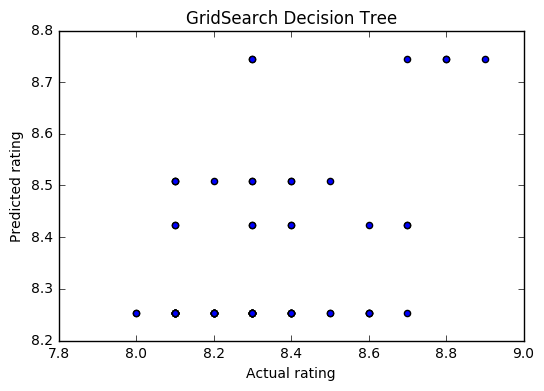

In [694]:
gs_model(gsdtr, "GridSearch Decision Tree", X_train, X_test, y_train, y_test)

#### 5.2 Random Forest

###### 5.2.1 Model build and performance check

In [695]:
# Build model
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

Random Forest CV Score:  0.366545051299 +/- 0.0204028921169
           importance
votes        0.611595
time         0.072505
1950s        0.033383
english      0.027293
oscar n/w    0.026068
Random Forest predicted MSE:  0.0307054794521
Random Forest predicted R2:  0.283144221502


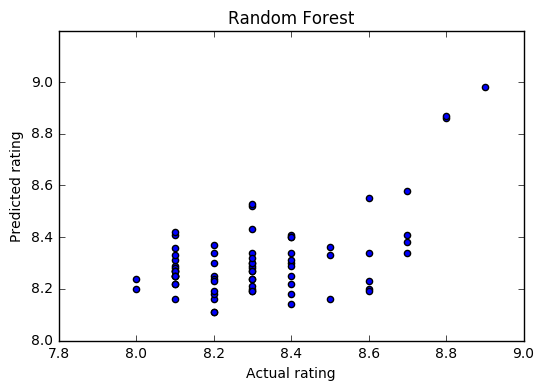

In [696]:
base_model(rfr, "Random Forest", X_train, X_test, y_train, y_test)

###### 5.2.2 Optimize base model

In [697]:
# Build model
params = {"min_samples_leaf": [1, 3, 5, 10],
          "n_estimators": [2, 5, 10, 20, 40],
          'max_features': ["auto", "sqrt", "log2", None],
          "max_depth": [3, 5, 10, 20, None],
          'min_samples_split': [2, 4, 7, 10],
          }
    
gsrfr = GridSearchCV(RandomForestRegressor(), params, n_jobs=-1, cv=5)

Best score:  0.440376228081
Best params:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 40, 'min_samples_leaf': 1, 'max_features': None}
Grid Search Random Forest Predicted MSE:  0.0283962088255
Grid Search Random Forest Predicted R2:  0.337056878862


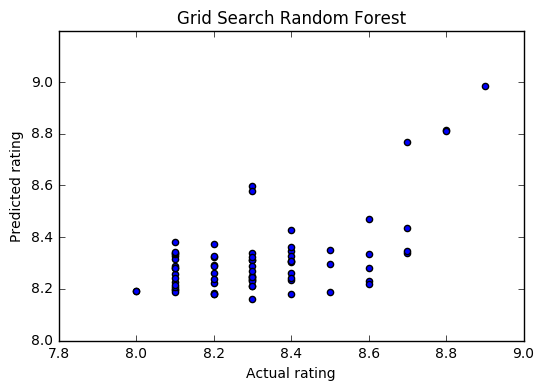

In [698]:
gs_model(gsrfr, "Grid Search Random Forest", X_train, X_test, y_train, y_test)

#### 5.3 Gradient Boosting

###### 5.3.1 Model build and performance check

In [699]:
# Build model
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

Gradient Boosting CV Score:  0.402363559912 +/- 0.0744555299612
           importance
votes        0.310948
time         0.126245
oscar n/w    0.046860
1950s        0.044201
comedy       0.040105
Gradient Boosting predicted MSE:  0.0290645660505
Gradient Boosting predicted R2:  0.321453287992


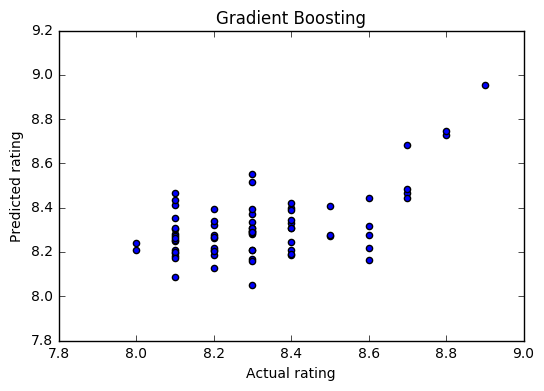

In [700]:
base_model(gbr, "Gradient Boosting", X_train, X_test, y_train, y_test)

###### 5.3.2 Optimize base model

In [710]:
# Build model
params = {"learning_rate": [0.05, 0.1, 0.2],
          "n_estimators": [10, 50, 100, 200, 300],
          'max_features': ["auto", "sqrt", "log2", None],
          "max_depth": [3, 5, 10, 20, None],
          'min_samples_split': [2, 4, 7, 10],
          }
    
gsgbr = GridSearchCV(GradientBoostingRegressor(), params, n_jobs=-1, cv=5)

Best score:  0.472835976652
Best params:  {'learning_rate': 0.2, 'min_samples_split': 10, 'max_features': 'auto', 'n_estimators': 50, 'max_depth': 3}
Grid Search Gradient Boosting Predicted MSE:  0.0292058177822
Grid Search Gradient Boosting Predicted R2:  0.318155599048


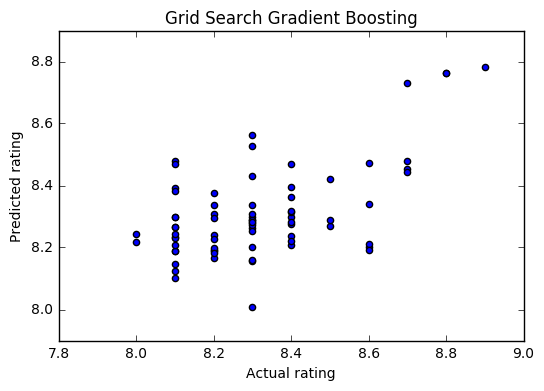

In [711]:
gs_model(gsgbr, "Grid Search Gradient Boosting", X_train, X_test, y_train, y_test)

#### 5.4 ExtraTrees

In [708]:
# Build model
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor()

ExtraTrees CV Score:  0.26321010726 +/- 0.150787098149
           importance
votes        0.365593
biography    0.058928
time         0.039180
hindi        0.037895
2000s        0.035358
ExtraTrees predicted MSE:  0.0308904109589
ExtraTrees predicted R2:  0.278826776483


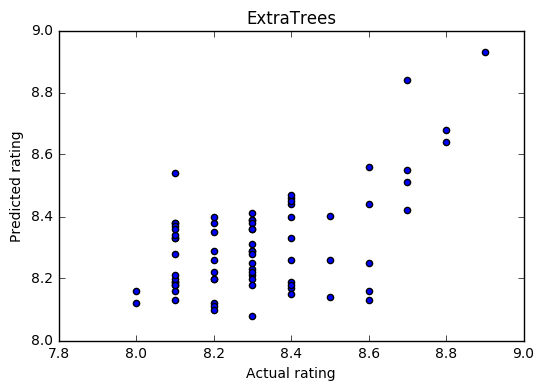

In [709]:
base_model(etr, "ExtraTrees", X_train, X_test, y_train, y_test)

## 6. Summary

|Method|MSE|R2|
|:----|:----:|:----:|
|Decision Tree|0.043|-0.013|
|GS Decision Tree|0.041|0.048|
|Random Forest|0.031|0.28|
|**GS Random Forest**|**0.028**|**0.34**|
|ExtraTrees|0.031|0.28|
|Gradient Boosting|0.029|0.32|
|GS Gradient Boosting|0.029|0.32|

**Number of votes** and **runtime** are the 2 biggest predictors of ratings for the IMDB Top 250 movies

## 7. Appendix

#### 7.1 Classification Tree

In [836]:
# Change y to categories
bins = [7.9, 8.4, 9.3]
group_names = [0, 1]
yc = pd.cut(y, bins, labels = group_names)

In [837]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, yc, stratify = yc, test_size = 0.3, 
                                                    random_state = 42)

In [838]:
# Build Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [839]:
# Fit and predict
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [840]:
# Prediction metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print("Accuracy: {0:.2f} ".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

[[51  3]
 [15  4]]
Accuracy: 0.75 
             precision    recall  f1-score   support

          0       0.77      0.94      0.85        54
          1       0.57      0.21      0.31        19

avg / total       0.72      0.75      0.71        73



In [841]:
# Feature importances
df = pd.DataFrame(rfc.feature_importances_, index = X_train.columns, columns=['importance']).\
                        sort_values('importance', ascending=False)
print(df[:5])

           importance
votes        0.237853
time         0.135250
oscar n/w    0.070447
1950s        0.029200
action       0.025125
